# preprocessing prototype code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from dask_jobqueue import SLURMCluster
import pyremo as pr
import cordex as cx
import xarray as xr
from pyintorg import interface as intf
from dask.distributed import Client, progress

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40543 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 262.14 GB


In [4]:
ta_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ta/gn/v20190710/ta_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
ps_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ps/gn/v20190710/ps_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197501010600-198001010000.nc"
hus_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/hus/gn/v20190710/hus_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
ua_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ua/gn/v20190815/ua_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
va_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/va/gn/v20190815/va_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
orog_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/fx/orog/gn/v20190710/orog_fx_MPI-ESM1-2-HR_historical_r1i1p1f1_gn.nc"

input_files = [orog_file, ta_file, ps_file, hus_file, ua_file, va_file]

In [5]:
surflib = pr.data.surflib('EUR-11', crop=False)
fibem = surflib.FIB * 1.0/0.10197

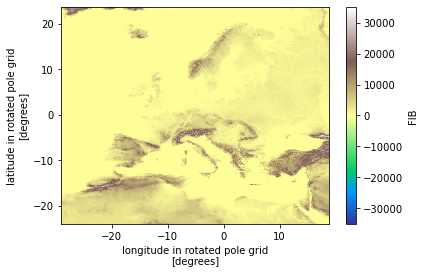

In [6]:
fibem.plot(cmap='terrain')

In [7]:
cx.__version__

'0.1.2+dev'

In [8]:
datasets = {'ta': ta_file, 
            'ps': ps_file,
            'hus': hus_file,
            'ua': ua_file,
            'va': va_file,
            #'orog': orog_file
           }

In [9]:
def open_mfdataset(files, use_cftime=True, parallel=True, data_vars='minimal', chunks={'time':1}, 
                   coords='minimal', compat='override', drop=None, **kwargs):
    """optimized function for opening CMIP6 6hrLev 3d datasets

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115
    
    """
    def drop_all_coords(ds):
        #ds = ds.drop(drop)
        return ds.reset_coords(drop=True)
    ds = xr.open_mfdataset(files, parallel=parallel, decode_times=False, combine='by_coords', 
                       preprocess=drop_all_coords, decode_cf=False, chunks=chunks,
                      data_vars=data_vars, coords='minimal', compat='override', **kwargs)
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [147]:
lev_gm = 'lev_gm'

In [148]:
from pyintorg import interface as intf


def horizontal_dims(da):
    for dim in da.dims:
        if 'lon' in dim:
            lon_dim = dim
        if 'lat' in dim:
            lat_dim = dim
    return (lon_dim, lat_dim)


def intersect(lamgm, phigm, lamem, phiem):
    gcm_dims = list(horizontal_dims(lamgm))
    rcm_dims = list(horizontal_dims(lamem))
    rcm_dims.append('pos')
    out_dims = rcm_dims
    #print(gcm_dims)
    #print(rcm_dims)
    #print(out_dims)
    result = xr.apply_ufunc(
        intf.intersection_points,  # first the function
        lamgm*1.0/57.296,  # now arguments in the order expected by 'druint'
        phigm*1.0/57.296,
        lamem*1.0/57.296,
        phiem*1.0/57.296,
        input_core_dims=[gcm_dims, gcm_dims, rcm_dims, rcm_dims],  # list with one entry per arg
        output_core_dims=[out_dims, out_dims],  # returned data has 3 dimensions
     #   vectorize=True,  # loop over non-core dims, in this case: time
     #   exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        output_dtypes=[lamgm.dtype]
    )
    return result


def interpolate_horizontal(da, lon, lat, name=None, igr=0):
    if name is None:
        name = da.name
    lamem, phiem = lon, lat
    #lamem = xr.concat([lamem, lamem, lamem], dim='pos')
    #phiem = xr.concat([phiem, phiem, phiem], dim='pos')
    lat2d, lon2d = xr.broadcast(ds.lat, ds.lon)
    lamgm, phigm = lon2d, lat2d
    indii, indjj = intersect(lamgm, phigm, lamem, phiem)
    return interp_horiz(da, lamgm, phigm,
                        lamem.isel(pos=igr), phiem.isel(pos=igr),
                        indii.isel(pos=igr), indjj.isel(pos=igr), name)


def interp_horiz_2d(field, lamgm, phigm, lamem, phiem, indii, indjj, name):
    """interpolates 2d global data horizontally.

    Interpolates 2d data from the global grid to the regional grid.
    """
    from intorg import intorg
    #if indii is None or indjj is None:
    #    indii, indjj = intersection_points(lamgm, phigm, lamem, phiem)
    return intorg.hiobla(field, lamgm, phigm, lamem, phiem, indii, indjj, name)


def interp_horiz(da, lamgm, phigm, lamem, phiem, indii, indjj, name, keep_attrs=False): 
    """main interface"""
    gcm_dims = list(horizontal_dims(lamgm))
    rcm_dims = list(horizontal_dims(lamem))
    input_core_dims = [gcm_dims, gcm_dims, gcm_dims, rcm_dims, rcm_dims , rcm_dims, rcm_dims, [] ]
    result = xr.apply_ufunc(
        interp_horiz_2d,  # first the function
        da,  # now arguments in the order expected
        lamgm*1.0/57.296,
        phigm*1.0/57.296,
        lamem*1.0/57.296,
        phiem*1.0/57.296,
        indii,
        indjj,
        name,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=[rcm_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
      #  exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[da.dtype]
    )

    result.name = name
    #result = result.to_dataset()
    if keep_attrs:
        result.attrs = da.attrs
    #result = result.transpose(..., *spatial_dims(da)[::-1])
    return result

def geopotential(fibgm, tgm, qdgm, psgm, akgm, bkgm):
    """main interface"""
    #gcm_dims = list(spatial_dims(lamgm))
    twoD_dims = list(horizontal_dims(fibgm))
    threeD_dims = list(horizontal_dims(fibgm))
    threeD_dims.append(lev_gm)
    #lev_dims.append("lev")
    #plev_dims = list(spatial_dims(da))
    #plev_dims.append("plev")
    #nlev = a.dims[0]
    input_core_dims = [twoD_dims, threeD_dims, threeD_dims, twoD_dims, ["lev_2"], ["lev_2"]]
    result = xr.apply_ufunc(
        intf.geopotential,  # first the function
        fibgm,  # now arguments in the order expected
        tgm,
        qdgm,
        psgm,
        akgm,
        bkgm,
        input_core_dims=input_core_dims,  # list with one entry per arg
      #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=[twoD_dims],  # returned data has 3 dimensions
       # vectorize=True,  # loop over non-core dims, in this case: time
       # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
      #  dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[fibgm.dtype]
    )
    return result


def relative_humidity(qdgm, tgm, psgm, akgm, bkgm, qwgm=None):
    """main interface"""
    if qwgm is None:
        qwgm = xr.zeros_like(qdgm)
    twoD_dims = list(horizontal_dims(qdgm))
    threeD_dims = list(horizontal_dims(qdgm)) + ['lev_gm']
  #  print(twoD_dims)
    #threeD_dims.append("lev")
    input_core_dims = [threeD_dims, threeD_dims, twoD_dims, [akgm.dims[0]], [bkgm.dims[0]], threeD_dims]
    result = xr.apply_ufunc(
        intf.relative_humidity,  # first the function
        qdgm,  # now arguments in the order expected
        tgm,
        psgm,
        akgm,
        bkgm,
        qwgm,
        input_core_dims=input_core_dims,  # list with one entry per arg
      #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
       # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
      #  dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[qdgm.dtype]
    )
    return result


def geo_coords(domain):
    import numpy as np
    ll_lam = domain.rlon[0] #* 1.0/57.296
    ll_phi = domain.rlat[0] #* 1.0/57.296
    dlam =  0.11
    dphi = 0.11
    nlam = domain.rlon.size
    nphi = domain.rlat.size
    pollam = domain.rotated_latitude_longitude.grid_north_pole_longitude
    polphi = domain.rotated_latitude_longitude.grid_north_pole_latitude
    lamem, phiem = intf.geo_coords(ll_lam, ll_phi, dlam, dphi, pollam, polphi, nlam+2, nphi+2)
    lamda = xr.DataArray(np.rad2deg(lamem), dims=('rlon', 'rlat', 'pos'), coords={'rlon':fibem.rlon, 'rlat':fibem.rlat})
    phida = xr.DataArray(np.rad2deg(phiem), dims=('rlon', 'rlat', 'pos'), coords={'rlon':fibem.rlon, 'rlat':fibem.rlat})
    return lamda, phida



In [11]:
domain = pr.remo_domain('EUR-11')
#domain_info = dm.domain_info('AFR-11')
lamem, phiem = geo_coords(domain)

In [152]:
import numpy as np

def get_vc(ds):
    """Reads the vertical hybrid coordinate from a dataset.
    """
    ak_valid = ['ap_bnds','a_bnds']
    bk_valid = ['b_bnds']
    ak_bnds = None
    bk_bnds = None
    for ak_name in ak_valid:
        if ak_name in ds:
            ak_bnds = ds[ak_name]
            print('using {} for akgm'.format(ak_name))
    for bk_name in bk_valid:
        if bk_name in ds:
            bk_bnds = ds[bk_name]
            print('using {} for bkgm'.format(bk_name))
#    if not all([ak_bnds, bk_bnds]):
#        print('could not identify vertical coordinate, tried: {}, {}'.format(ak_valid, bk_valid))
#        raise Exception('incomplete input dataset')
#        ak_bnds, bk_bnds  = (ak_bnds[:1], bk_bnds[:,1])
    nlev = ak_bnds.shape[0]
    ak = np.zeros([nlev+1], dtype=np.float64)
    bk = np.ones([nlev+1], dtype=np.float64)
    if ds.lev.positive == "down":
        ak[:-1] = np.flip(ak_bnds[:,1])
        bk[:-1] = np.flip(bk_bnds[:,1])
    else:
        ak[1:] = np.flip(ak_bnds[:,1])
        bk[1:] = np.flip(bk_bnds[:,1])
        
    return xr.DataArray(ak, dims="lev_2"), xr.DataArray(bk, dims="lev_2")

def gfile(datasets, ref_ds, time_range = None):
    """Creates a virtual gfile
    """
    if time_range is None:
        time_range=slice("1979-01-01T06:00:00", "1979-01-31T18:00:00")
    dsets = []
    for var, f in datasets.items():
        da = open_mfdataset(f)[var].sel(time=time_range)
        try:
            if da.lev.positive == "down":
                da = da.reindex(lev=da.lev[::-1])
        except:
            pass
        dsets.append(da)
            
    #dsets = [open_mfdataset(f)[var].sel(time=time_range) for var, f in datasets.items()]
    #dsets.append(orog_ds.orog)
    ds = xr.merge(dsets, compat="override")
    ds["akgm"], ds["bkgm"] = get_vc(ref_ds)
    ds = ds.rename({'lev':lev_gm})
    #ds["akgm"], ds["bkgm"] = get_vc(ref_ds)
    #if ds.lev.positive == "down":
    #    ds.reindex(lev=ds.lev[::-1])
    ds.attrs = ref_ds.attrs
    return ds

In [153]:
ref_ds = open_mfdataset(ta_file)
orog_ds = open_mfdataset(orog_file, chunks="auto")
orog_ds

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 192, lon: 384)
Coordinates:
  * lat       (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon       (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(384, 2), meta=np.ndarray>
    orog      (lat, lon) float32 dask.array<chunksize=(192, 384), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    tracking_id:            hdl:21.14100/3341d289-1282-489f-9419-c263718da247
    variable_id:            orog
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0

In [154]:
ds = gfile(datasets, ref_ds, time_range = slice("1979-01-01T06:00:00", "1979-01-31T18:00:00"))

/work/ch0636/g300046/conda_envs/pyremo/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/work/ch0636/g300046/conda_envs/pyremo/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.arr

using ap_bnds for akgm
using b_bnds for bkgm


/work/ch0636/g300046/conda_envs/pyremo/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


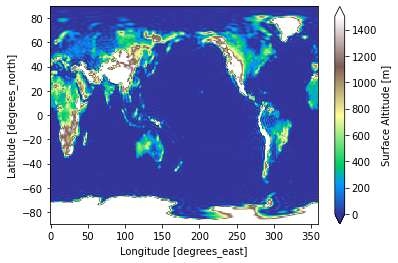

In [155]:
orog_ds["lon"] = ds.lon
orog_ds["lat"] = ds.lat
ds["orog"] = orog_ds.orog
ds.orog.plot(cmap="terrain", vmin=0, vmax=1500)

In [156]:
ds

<xarray.Dataset>
Dimensions:  (lat: 192, lev_2: 96, lev_gm: 95, lon: 384, time: 123)
Coordinates:
  * lev_gm   (lev_gm) float64 9.816e-06 2.31e-05 3.079e-05 ... 0.9826 0.9961
  * time     (time) object 1979-01-01 06:00:00 ... 1979-01-31 18:00:00
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: lev_2
Data variables:
    ta       (time, lev_gm, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    ps       (time, lat, lon) float32 dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    hus      (time, lev_gm, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    ua       (time, lev_gm, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    va       (time, lev_gm, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    akgm     (lev_2) float64 0.0 1.989 2.693 3.546 4.577 ... 72.06 0.0 0.0 0.0
    bkgm     (lev_2) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9442 0.973 0.9923 1.0
    orog     (lat, lon) float32 dask.array<chunksize=(192, 384), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/e7cf2db1-51d1-4692-a1ff-60e2d204b533

In [157]:
#fak_fib = 1.0 # era5
#fak_bla = 1.0 # era5

fak_fib = 1.0/0.10197 # = gravitational constant if unit is 'm'
fak_bla = 0.01 # if unit is '%'

In [158]:
tge = interpolate_horizontal(ds.ta, lamem, phiem, 'T')
psge = interpolate_horizontal(ds.ps, lamem, phiem, 'PS')
uge = interpolate_horizontal(ds.ua, lamem, phiem, 'U', 1)
uvge = interpolate_horizontal(ds.ua, lamem, phiem, 'U', 2)
vge = interpolate_horizontal(ds.va, lamem, phiem, 'V', 2)
vuge = interpolate_horizontal(ds.va, lamem, phiem, 'V', 1)
qdge = interpolate_horizontal(ds.hus, lamem, phiem, 'QD')
fibge = interpolate_horizontal(ds.orog*fak_fib, lamem, phiem, 'FIB')

### geopotential

In [159]:
ficgm = geopotential(ds.orog*fak_fib, ds.ta.isel(time=0), ds.hus.isel(time=0), ds.ps.isel(time=0), ds.akgm, ds.bkgm).squeeze(drop=True)
ficge = interpolate_horizontal(ficgm, lamem, phiem, 'FIC')
arfgm = relative_humidity(ds.hus, ds.ta, ds.ps, ds.akgm, ds.bkgm)
arfge = interpolate_horizontal(arfgm, lamem, phiem, 'AREL HUM')

In [24]:
#RELHUM: hur relative_humidity
#QD hus specific_humidity
#QW: clw mass_fraction_of_cloud_liquid_water_in_air

### rotate UV

In [241]:
def rotate_uv(uge, vge, uvge, vuge, lamem, phiem, pollam, polphi):
    ulamem, uphiem = lamem.isel(pos=1), phiem.isel(pos=1)
    vlamem, vphiem = lamem.isel(pos=2), phiem.isel(pos=2)
    twoD_dims = list(horizontal_dims(uge))
    input_core_dims = 4*[twoD_dims+[lev_gm]] + 4*[twoD_dims] + 2*[[]]
    print(input_core_dims)
    uge_rot, vge_rot = xr.apply_ufunc(
        intf.rotate_uv,  # first the function
        uge,  # now arguments in the order expected
        vge,
        uvge,
        vuge,
        ulamem*1.0/57.296,
        uphiem*1.0/57.296,
        vlamem*1.0/57.296,
        vphiem*1.0/57.296,
        pollam,
        polphi,
        input_core_dims=input_core_dims,  # list with one entry per arg
      #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=2*[twoD_dims+[lev_gm]],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
       # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
      #  dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[uge.dtype, vge.dtype]
    )
    return uge_rot, vge_rot

In [222]:
uge

,Array,Chunk
Bytes,8.84 GB,71.91 MB
Shape,"(123, 95, 435, 435)","(1, 95, 435, 435)"
Count,3666 Tasks,123 Chunks
Type,float32,numpy.ndarray


In [242]:
pollon = domain.rotated_latitude_longitude.grid_north_pole_longitude
pollat = domain.rotated_latitude_longitude.grid_north_pole_latitude
uge_rot, vge_rot = rotate_uv(uge, vge, uvge, vuge, lamem, phiem, pollon, pollat)

[['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], [], []]


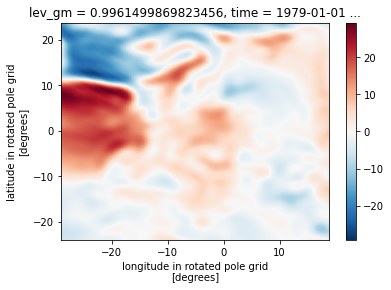

In [243]:
uge_rot.isel(time=0, lev_gm=94).plot(x='rlon', y='rlat')

### first pressure correction

In [244]:
def pressure_correction_em(psge, tge, arfge, fibge, fibem, akgm, bkgm, kpbl):
    twoD_dims = list(horizontal_dims(psge))
    threeD_dims = list(horizontal_dims(psge)) + [lev_gm]
    input_core_dims = ( [twoD_dims] + 2*[threeD_dims] + 2*[twoD_dims] + 
                       [[akgm.dims[0]], [bkgm.dims[0]],[]] )
    print(input_core_dims)
    result = xr.apply_ufunc(
        intf.pressure_correction_em,  # first the function
        psge,  # now arguments in the order expected
        tge,
        arfge,
        fibge,
        fibem,
        akgm,
        bkgm,
        kpbl,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=[twoD_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
        dask="parallelized",
        output_dtypes=[psge.dtype]
    )
    return result

In [245]:
kpbl = intf.pbl_index(ds.akgm, ds.bkgm)
kpbl

89

In [246]:
ps1em = pressure_correction_em(psge, tge, arfge, fibge, fibem, ds.akgm, ds.bkgm, kpbl)

[['rlon', 'rlat'], ['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['lev_2'], ['lev_2'], []]


In [247]:
ps1em

<xarray.DataArray (time: 123, rlon: 435, rlat: 435)>
dask.array<transpose, shape=(123, 435, 435), dtype=float32, chunksize=(1, 435, 435), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1979-01-01 06:00:00 ... 1979-01-31 18:00:00
  * rlon     (rlon) float64 -29.04 -28.93 -28.82 -28.71 ... 18.48 18.59 18.71
  * rlat     (rlat) float64 -24.04 -23.93 -23.82 -23.71 ... 23.48 23.59 23.71

### vertical interpolation

In [248]:
def interpolate_vertical(xge, psge, ps1em, akhgm, bkhgm, akhem, bkhem, varname, kpbl):
    twoD_dims = list(horizontal_dims(psge))
    threeD_dims = list(horizontal_dims(psge)) + [lev_gm]
    input_core_dims = ( [threeD_dims] + 2*[twoD_dims] + 
                        [[akhgm.dims[0]], [bkhgm.dims[0]], [akhem.dims[0]], [bkhem.dims[0]],[], []] )
    output_core_dims = [twoD_dims+[akhem.dims[0]]]
    print(output_core_dims)
    result = xr.apply_ufunc(
        intf.interp_vert,  # first the function
        xge,  # now arguments in the order expected
        psge,
        ps1em,
        akhgm,
        bkhgm,
        akhem,
        bkhem,
        varname,
        kpbl,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=output_core_dims,  # returned data has 3 dimensions
        #exclude_dims=set(("index",)),
        vectorize=True,  # loop over non-core dims, in this case: time
        dask="parallelized",
        output_dtypes=[xge.dtype]
    )
    return result


#interp_vert(tge, psge, ps1em, varmap.akhgm, varmap.bkhgm, varmap.akhem, varmap.bkhem, varname, kpbl)

In [249]:
akhgm = 0.5 * (ds.akgm[:-1] + ds.akgm[1:])
bkhgm = 0.5 * (ds.bkgm[:-1] + ds.bkgm[1:])
dakgm = ds.akgm[1:] - ds.akgm[:-1]
dbkgm = ds.bkgm[1:] - ds.bkgm[:-1]

In [284]:
pr.vc.tables.keys()

dict_keys(['vc_27lev', 'vc_40lev', 'vc_49lev', 'vc_49lev_nh_pt2000', 'vc_60lev_ecmwf', 'vc_91lev_ecmwf', 'vc_101lev_100m_pt27713', 'vc_144lev_equal_pdiff_pt6400'])

In [288]:
lev_i = 'lev_i'
lev = 'lev'
# it's important to drop the index so that xarray does not
akbk = pr.vc.tables['vc_91lev_ecmwf'].to_xarray().drop('index')
#bkem = pr.tables.vc.tables['vc_27lev']
akem = akbk.ak.swap_dims({'index':lev_i})
bkem = akbk.bk.swap_dims({'index':lev_i})
akhem = (0.5 * (akbk.ak[:-1] + akbk.ak[1:])).swap_dims({'index':lev})
bkhem = (0.5 * (akbk.bk[:-1] + akbk.bk[1:])).swap_dims({'index':lev})

In [289]:
akem[lev_i] = xr.DataArray(np.arange(1,akem.size+1), dims=lev_i)
bkem[lev_i] = xr.DataArray(np.arange(1,bkem.size+1), dims=lev_i)
akhem[lev] = xr.DataArray(np.arange(1,akhem.size+1), dims=lev)
bkhem[lev] = xr.DataArray(np.arange(1,bkhem.size+1), dims=lev)

In [290]:
akhem

<xarray.DataArray 'ak' (lev: 91)>
array([1.00002000e+00, 2.99043600e+00, 5.68400900e+00, 1.01477525e+01,
       1.71609655e+01, 2.76832350e+01, 4.28497295e+01, 6.39571285e+01,
       9.24416085e+01, 1.29850792e+02, 1.77811737e+02, 2.37996979e+02,
       3.12090500e+02, 4.01755142e+02, 5.08602508e+02, 6.34166290e+02,
       7.79879577e+02, 9.47056153e+02, 1.13687598e+03, 1.35037469e+03,
       1.58843677e+03, 1.85179199e+03, 2.14101495e+03, 2.45652698e+03,
       2.79860034e+03, 3.16736401e+03, 3.56281091e+03, 3.98480627e+03,
       4.43309644e+03, 4.90731812e+03, 5.40700806e+03, 5.93149780e+03,
       6.47978320e+03, 7.05059839e+03, 7.64219800e+03, 8.25377515e+03,
       8.88646484e+03, 9.54093311e+03, 1.02162212e+04, 1.09106831e+04,
       1.16225732e+04, 1.23482798e+04, 1.30835615e+04, 1.38226177e+04,
       1.45573477e+04, 1.52803696e+04, 1.59838071e+04, 1.66600918e+04,
       1.73019521e+04, 1.79021553e+04, 1.84539990e+04, 1.89507568e+04,
       1.93860293e+04, 1.97536553e+04, 2.00475957e+04, 2.02621553e+04,
       2.03915371e+04, 2.04301885e+04, 2.03726152e+04, 2.02130215e+04,
       1.99461943e+04, 1.95670664e+04, 1.90737988e+04, 1.84700596e+04,
       1.77634463e+04, 1.69650908e+04, 1.60890762e+04, 1.51496060e+04,
       1.41594326e+04, 1.31308018e+04, 1.20757754e+04, 1.10072388e+04,
       9.93826660e+03, 8.88073779e+03, 7.84570874e+03, 6.84454272e+03,
       5.88836182e+03, 4.98650928e+03, 4.14684009e+03, 3.37680566e+03,
       2.68317480e+03, 2.07052863e+03, 1.54125537e+03, 1.09642484e+03,
       7.35753845e+02, 4.56543259e+02, 2.49407898e+02, 1.08125882e+02,
       3.03919820e+01, 3.28939400e+00, 1.58000000e-03])
Coordinates:
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 ... 82 83 84 85 86 87 88 89 90 91

In [291]:
dakhgm = ds.akgm.diff(dim='lev_2')
dbkhgm = ds.bkgm.diff(dim='lev_2')

In [292]:
tge

,Array,Chunk
Bytes,8.84 GB,71.91 MB
Shape,"(123, 95, 435, 435)","(1, 95, 435, 435)"
Count,3666 Tasks,123 Chunks
Type,float32,numpy.ndarray


In [293]:
tem = interpolate_vertical(tge, psge, ps1em, akhgm, bkhgm, 
                           akhem, bkhem, 'T', kpbl)
arfem = interpolate_vertical(arfge, psge, ps1em, akhgm, bkhgm, 
                           akhem, bkhem, 'RF', kpbl)

[['rlon', 'rlat', 'lev']]
[['rlon', 'rlat', 'lev']]


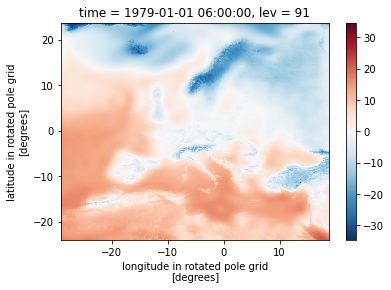

In [297]:
(tem.isel(time=0, lev=90)-273.5).plot(x='rlon', y='rlat')

### second pressure correction

In [298]:
def pressure_correction_ge(ps1em, tem, arfem, ficge, fibem, akem, bkem):
    twoD_dims = list(horizontal_dims(psge))
    threeD_dims = list(horizontal_dims(psge)) + [lev]
    input_core_dims = ( [twoD_dims] + 2*[threeD_dims] + 2*[twoD_dims] + 
                       [[akem.dims[0]], [bkem.dims[0]]] )
    print(input_core_dims)
    result = xr.apply_ufunc(
        intf.pressure_correction_ge,  # first the function
        ps1em,  # now arguments in the order expected
        tem,
        arfem,
        ficge,
        fibem,
        akem,
        bkem,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=[twoD_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
        dask="parallelized",
        output_dtypes=[ps1em.dtype]
    )
    return result

In [299]:
tem

,Array,Chunk
Bytes,8.47 GB,68.88 MB
Shape,"(123, 435, 435, 91)","(1, 435, 435, 91)"
Count,24413 Tasks,123 Chunks
Type,float32,numpy.ndarray


In [300]:
psem = pressure_correction_ge(ps1em, tem, arfem, ficge, fibem, akem, bkem)

[['rlon', 'rlat'], ['rlon', 'rlat', 'lev'], ['rlon', 'rlat', 'lev'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['lev_i'], ['lev_i']]


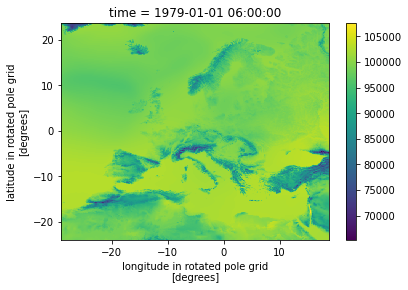

In [301]:
psem[0].plot(x='rlon', y='rlat')

In [302]:
uem = interpolate_vertical(uge_rot, psge, psem, akhgm, bkhgm, 
                           akhem, bkhem, 'U', kpbl)
vem = interpolate_vertical(vge_rot, psge, ps1em, akhgm, bkhgm, 
                           akhem, bkhem, 'V', kpbl)

[['rlon', 'rlat', 'lev']]
[['rlon', 'rlat', 'lev']]


In [303]:
uem

,Array,Chunk
Bytes,8.47 GB,68.88 MB
Shape,"(123, 435, 435, 91)","(1, 435, 435, 91)"
Count,34465 Tasks,123 Chunks
Type,float32,numpy.ndarray


In [306]:
xem_ = tem.isel(time=0).persist()
progress(xem_)

VBox()

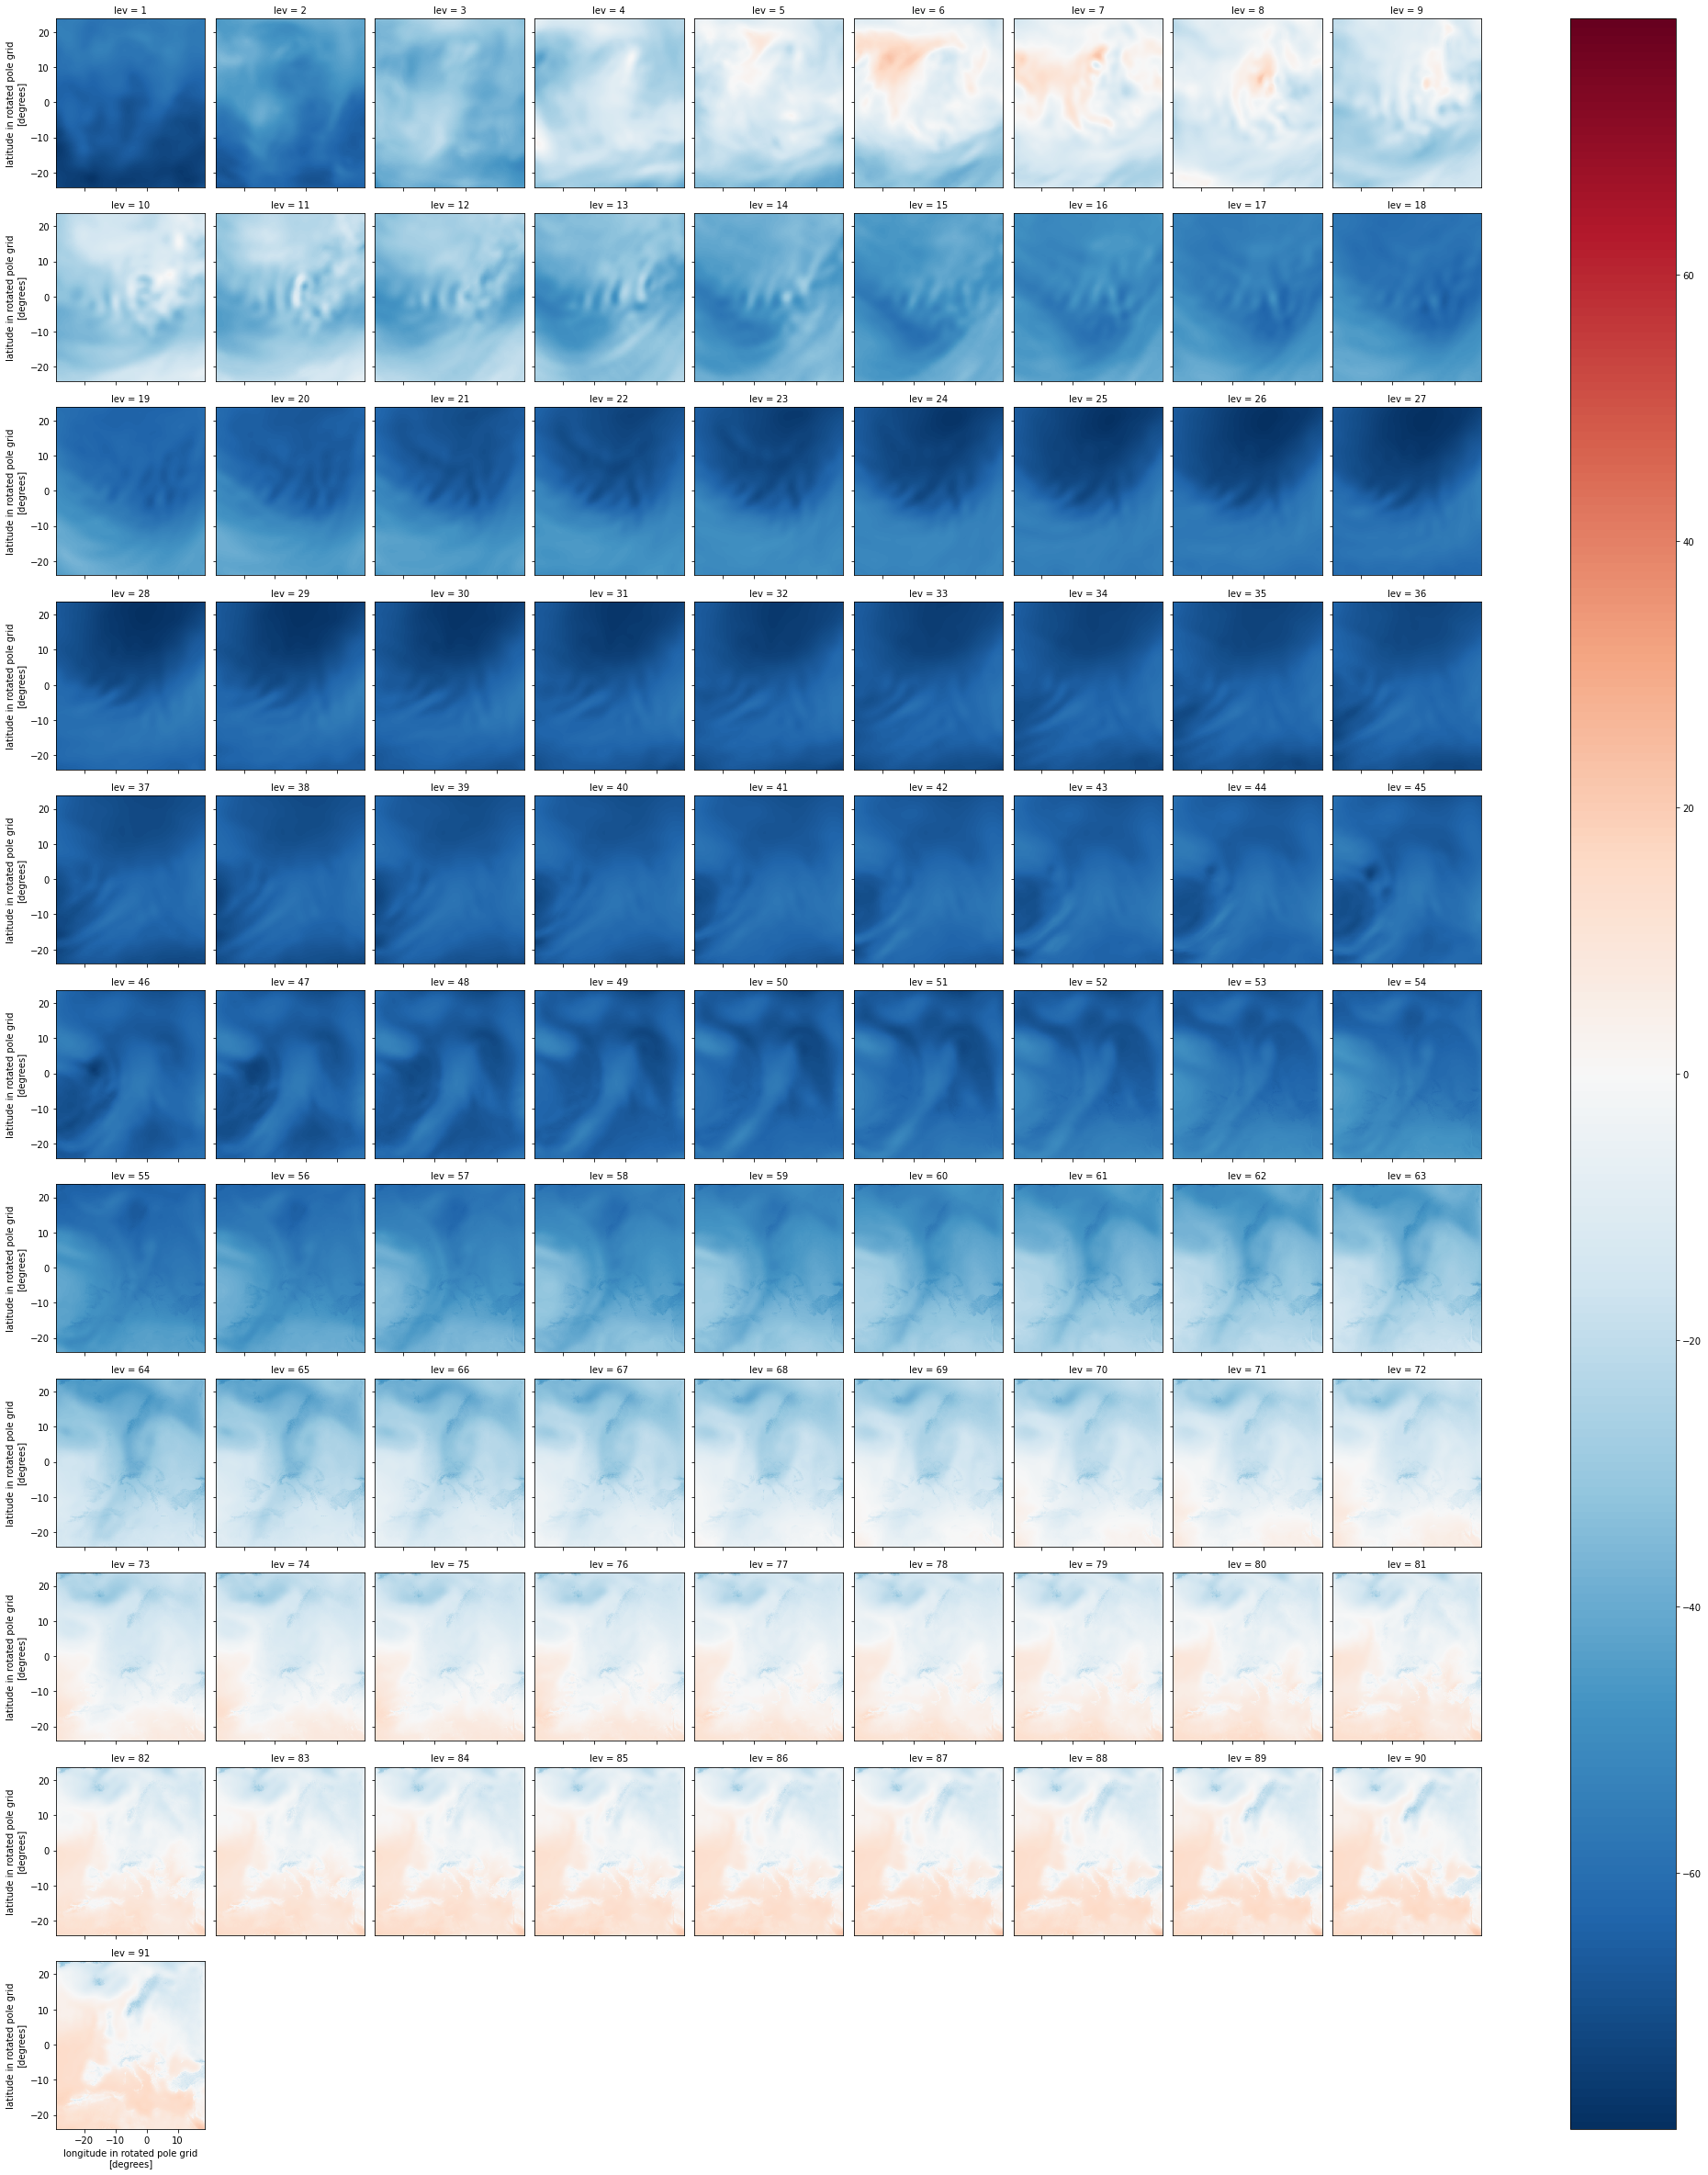

In [308]:
(xem_-273.5).plot(x='rlon', y='rlat', col=lev, col_wrap=9)

In [265]:
def correct_uv(uem, vem, psem, akem, bkem, ll_lam, dlam, dphi):
    ulamem, uphiem = lamem.isel(pos=1), phiem.isel(pos=1)
    vlamem, vphiem = lamem.isel(pos=2), phiem.isel(pos=2)
    twoD_dims = list(horizontal_dims(uem))
    input_core_dims = 2*[twoD_dims+[lev]] + 1*[twoD_dims] + [[akem.dims[0]], [bkem.dims[0]]] + 3*[[]]
    print(input_core_dims)
    uge_corr, vge_corr = xr.apply_ufunc(
        intf.correct_uv,  # first the function
        uem,  # now arguments in the order expected
        vem,
        psem,
        akem,
        bkem,
        ll_lam,
        dlam,
        dphi,
        input_core_dims=input_core_dims,  # list with one entry per arg
      #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=2*[twoD_dims+[lev]],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
       # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
      #  dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[uem.dtype, vem.dtype]
    )
    return uge_corr, vge_corr

In [266]:
philuem = pr.domain_info('EUR-11')['ll_lon']
dlamem = pr.domain_info('EUR-11')['dlon']
dphiem = pr.domain_info('EUR-11')['dlat']
philuem, dlamem, dphiem

(-28.925, 0.11, 0.11)

In [267]:
uem_corr, vem_corr = correct_uv(uem, vem, psem, akem, bkem, philuem, dlamem, dphiem)

[['rlon', 'rlat', 'lev'], ['rlon', 'rlat', 'lev'], ['rlon', 'rlat'], ['lev_i'], ['lev_i'], [], [], []]


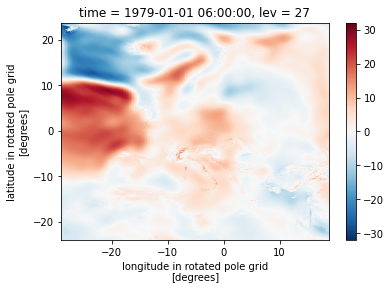

In [268]:
uem_corr.isel(time=0, lev=26).plot(x='rlon', y='rlat')